<a href="https://colab.research.google.com/github/thayyilakul/Tensorflow-ML/blob/main/Sarcasm_detection_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [ ]:
df = pd.read_json('/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json', lines = True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
len(df)

26709

In [ ]:
df.is_sarcastic.value_counts()

is_sarcastic
0    14985
1    11724
Name: count, dtype: int64

In [ ]:
df.isna().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [ ]:
df.loc[2].headline

"mom starting to fear son's web series closest thing she will have to grandchild"

In [ ]:
import random
random_index = random.randint(0, len(df) - 5)
for row in df[['headline', 'is_sarcastic']][random_index : random_index + 5].itertuples():
    _ , headline, is_sarcastic = row
    print(f'Headline - {headline}')
    print(f"Is sarcastic : {'Yes' if is_sarcastic == 1 else 'No'}")
    print('-----')

Headline - jesse williams set to be honored with humanitarian award at the 2016 bet awards
Is sarcastic : No
-----
Headline - greyhound now offering direct service from kansas to l.a. porn director's driveway
Is sarcastic : Yes
-----
Headline - nike ceo blasts trump executive order targeting muslims, refugees
Is sarcastic : No
-----
Headline - 5 ways to get more out of your classes this fall
Is sarcastic : No
-----
Headline - rick santorum slightly embarrassed for man introducing him as next president of united states
Is sarcastic : Yes
-----


In [ ]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(df['headline'].to_numpy(),
                                                                           df['is_sarcastic'].to_numpy(),
                                                                           test_size = 0.1,
                                                                           random_state = 42)

len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(24038, 2671, 24038, 2671)

In [ ]:
train_sentences[:10], train_labels[:10]

(array(['win a $10,000 mall of america dream shooting spree!',
        'cash-strapped oklahoma to conduct executions by hammering squad',
        'what will the disruption of politics look like?',
        'three qualities a woman should possess to be powerful, from jill abramson (video)',
        "david petraeus: white house is wrong, generals are 'fair game' for criticism",
        'queen bun gives birth to thousands of tiny rolls',
        "behind the black curtain with tom brady: tears and concerns over patriots' dynasty",
        'your four-legged friends are leaving a serious carbon pawprint on the planet',
        'herpetologist names son after famous herpetologist',
        'should banks be allowed to robocall your mobile phone?'],
       dtype=object),
 array([1, 1, 0, 0, 0, 1, 0, 0, 1, 0]))

In [ ]:
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

10

In [ ]:
from tensorflow.keras.layers import TextVectorization

max_length = 10
max_vocab_length = 10000

text_vectorizer = TextVectorization(
    max_tokens = max_vocab_length,
    standardize = 'lower_and_strip_punctuation',
    split = 'whitespace',
    ngrams = None,
    output_mode = 'int',
    output_sequence_length = max_length
)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
sample_sentence = 'Today is a good day!'
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 10), dtype=int64, numpy=array([[473,  11,   7, 115,  53,   0,   0,   0,   0,   0]])>

In [ ]:
random_sentence = random.choice(train_sentences)
print(f'Original Text : {random_sentence}\n')
print(f'Vectorized version : {text_vectorizer([random_sentence])}')

Original Text : islamic fundamentalists condemn casual day

Vectorized version : [[1746    1 5317 3481   53    0    0    0    0    0]]


In [ ]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f'Top 5 Words : {top_5_words}\n')
print(f'Bottom 5 Words : {bottom_5_words}')

Top 5 Words : ['', '[UNK]', 'to', 'of', 'the']

Bottom 5 Words : ['waffle', 'wackiest', 'waaah', 'vuitton', 'vu']


In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(
    input_dim = max_vocab_length,
    output_dim = 128,
    embeddings_initializer = 'uniform',
    input_length = max_length,
    name = 'embedding_1'
)

embedding

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<Embedding name=embedding_1, built=False>

In [ ]:
random_sentence = random.choice(train_sentences)
print(f'Original Text : {random_sentence}\n')
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original Text : advertising executive gets in touch with inner-child demographic



<tf.Tensor: shape=(1, 10, 128), dtype=float32, numpy=
array([[[-0.00291966, -0.03155319, -0.03350507, ...,  0.00438061,
         -0.0071167 , -0.03077346],
        [ 0.01377063,  0.01125992, -0.00793005, ..., -0.01787164,
          0.04975642,  0.03483764],
        [ 0.00399815, -0.0471612 , -0.02498093, ..., -0.01648606,
          0.04971974,  0.04261136],
        ...,
        [-0.01851531,  0.04191304, -0.02616967, ...,  0.01496711,
          0.02545129,  0.00918348],
        [ 0.03943844,  0.03173405, -0.0395514 , ...,  0.02505289,
         -0.03854492, -0.04758947],
        [ 0.03943844,  0.03173405, -0.0395514 , ...,  0.02505289,
         -0.03854492, -0.04758947]]], dtype=float32)>

In [ ]:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.00291966, -0.03155319, -0.03350507, -0.0299318 , -0.0350978 ,
       -0.03758235, -0.04552674, -0.04055486, -0.03581464,  0.02734163,
       -0.0302178 ,  0.00532118,  0.03616067, -0.02834741,  0.01943571,
        0.00117624,  0.04198483,  0.02633449,  0.03232962, -0.04528279,
       -0.03924274, -0.02371041, -0.0086378 , -0.00148749, -0.03733482,
       -0.02404288,  0.03642765,  0.03193119, -0.00118508, -0.01452289,
       -0.041153  , -0.04257286, -0.00622318, -0.03935651, -0.01097959,
       -0.02017895,  0.04496257,  0.03903789, -0.04456766,  0.03195361,
       -0.00648195, -0.03584617,  0.0357405 , -0.0248704 , -0.02271121,
        0.02010773,  0.01183451,  0.02549085, -0.00832297,  0.04558544,
        0.01513753, -0.01975244, -0.02338312,  0.03067118,  0.03642675,
        0.01512558, -0.03231108, -0.03937503,  0.00955783,  0.03095288,
       -0.01170782,  0.01808322, -0.03348192, -0.00811835,  0.01038759,
        0.014379

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0_score = model_0.score(val_sentences, val_labels)
print(f'Baseline accuracy score is {model_0_score*100:.2f}%')

Baseline accuracy score is 81.95%


In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([1, 0, 0, ..., 0, 0, 1])

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average = 'weighted')
    return {
        'accuracy' : model_accuracy,
        'recall' : model_recall,
        'precision' : model_precision,
        'f1' : model_f1
    }

In [ ]:
baseline_results = calculate_results(val_labels, baseline_preds)
baseline_results

{'accuracy': 81.9543242231374,
 'recall': 0.819543242231374,
 'precision': 0.8293929484154704,
 'f1': 0.8148942031170678}

In [ ]:
import tensorflow as tf

inputs = layers.Input(shape = (1, ), dtype = 'string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs, name = 'model_1_dense')

In [ ]:
model_1.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

In [ ]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 10)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 10, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_1_history = model_1.fit(train_sentences,
                             train_labels,
                             epochs = 5,
                             validation_data = (val_sentences, val_labels))

Epoch 1/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7361 - loss: 0.5514 - val_accuracy: 0.8476 - val_loss: 0.3628
Epoch 2/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8762 - loss: 0.3041 - val_accuracy: 0.8521 - val_loss: 0.3518
Epoch 3/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9060 - loss: 0.2364 - val_accuracy: 0.8491 - val_loss: 0.3758
Epoch 4/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9242 - loss: 0.1973 - val_accuracy: 0.8428 - val_loss: 0.4141
Epoch 5/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9375 - loss: 0.1705 - val_accuracy: 0.8297 - val_loss: 0.4608


In [ ]:
model_1.evaluate(val_sentences, val_labels)

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8393 - loss: 0.4420


[0.4607945382595062, 0.8296518325805664]

In [ ]:
embedding.weights

[<KerasVariable shape=(10000, 128), dtype=float32, path=embedding_1/embeddings>]

In [ ]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[9.9775195e-01],
       [1.5027408e-01],
       [1.3191272e-01],
       [4.7634253e-01],
       [6.6940361e-01],
       [9.6209002e-01],
       [2.4095995e-04],
       [6.0990363e-01],
       [2.4794384e-03],
       [8.9325085e-03]], dtype=float32)

In [ ]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 0., 0., 1., 1., 0., 1., 0., 0.], dtype=float32)>

In [ ]:
model_1_results = calculate_results(val_labels, model_1_preds)
model_1_results

{'accuracy': 82.96518157993262,
 'recall': 0.8296518157993261,
 'precision': 0.8303040815212329,
 'f1': 0.8298795197681974}

In [ ]:
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([ True,  True,  True,  True])

In [ ]:
def compare_baseline_to_new_results(baseline_results, new_model_results):
    for key, value in baseline_results.items():
        print(f'Baseline {key}:{value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference : {new_model_results[key] - value:.2f}')

compare_baseline_to_new_results(baseline_results, model_1_results)

Baseline accuracy:81.95, New accuracy: 82.97, Difference : 1.01
Baseline recall:0.82, New recall: 0.83, Difference : 0.01
Baseline precision:0.83, New precision: 0.83, Difference : 0.00
Baseline f1:0.81, New f1: 0.83, Difference : 0.01


In [ ]:
tf.random.set_seed(42)

model_2_embedding = layers.Embedding(input_dim = max_vocab_length,
                                    output_dim = 128,
                                    embeddings_initializer = 'uniform',
                                    input_length = max_length,
                                    name = 'embedding_2')

inputs = layers.Input(shape = (1, ), dtype = 'string')
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name = 'model_2_LSTM')

(None, 10, 128)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
def compile_and_display_model_summary(model, loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']):
    model.compile(loss = loss,
                 optimizer = optimizer,
                 metrics = metrics)
    return model.summary()

In [ ]:
model_2_compile_display_summary = compile_and_display_model_summary(model_2)
model_2_compile_display_summary

Model: "model_2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 10)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 10, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def model_fit(model):
    return model.fit(train_sentences,
                    train_labels,
                    epochs = 5,
                    validation_data = (val_sentences, val_labels))

In [ ]:
model_2_fit = model_fit(model_2)
model_2_fit

Epoch 1/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7658 - loss: 0.4621 - val_accuracy: 0.8506 - val_loss: 0.3442
Epoch 2/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9029 - loss: 0.2400 - val_accuracy: 0.8398 - val_loss: 0.4178
Epoch 3/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9496 - loss: 0.1346 - val_accuracy: 0.8117 - val_loss: 0.6266
Epoch 4/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9746 - loss: 0.0720 - val_accuracy: 0.8128 - val_loss: 0.6626
Epoch 5/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9828 - loss: 0.0530 - val_accuracy: 0.8064 - val_loss: 0.6729


In [ ]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


array([[9.99933839e-01],
       [8.74600261e-02],
       [9.25441682e-02],
       [7.83085227e-01],
       [2.36686155e-01],
       [9.98341620e-01],
       [9.05818015e-04],
       [8.46972346e-01],
       [1.14768736e-01],
       [1.29818292e-02]], dtype=float32)

In [ ]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 0., 1., 0., 1., 0., 1., 0., 0.], dtype=float32)>

In [ ]:
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 80.64395357543991,
 'recall': 0.8064395357543991,
 'precision': 0.8078759931516329,
 'f1': 0.8068628216565336}

In [ ]:
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy:81.95, New accuracy: 80.64, Difference : -1.31
Baseline recall:0.82, New recall: 0.81, Difference : -0.01
Baseline precision:0.83, New precision: 0.81, Difference : -0.02
Baseline f1:0.81, New f1: 0.81, Difference : -0.01


In [ ]:
tf.random.set_seed(42)

model_3_embedding = layers.Embedding(input_dim = max_vocab_length,
                                    output_dim = 128,
                                    embeddings_initializer = 'uniform',
                                    input_length = max_length,
                                    name = 'embedding_3')

inputs = layers.Input(shape = (1, ), dtype = 'string')
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name = 'model_3_GRU')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model_3_compile_display_summary = compile_and_display_model_summary(model_3)
model_3_compile_display_summary

Model: "model_3_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 10)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, 10, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,317,313 (5.03 MB)

 Trainable params: 1,317,313 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_3_fit = model_fit(model_3)
model_3_fit

Epoch 1/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7484 - loss: 0.4819 - val_accuracy: 0.8525 - val_loss: 0.3475
Epoch 2/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9020 - loss: 0.2462 - val_accuracy: 0.8458 - val_loss: 0.3950
Epoch 3/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9481 - loss: 0.1410 - val_accuracy: 0.8233 - val_loss: 0.5339
Epoch 4/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9742 - loss: 0.0826 - val_accuracy: 0.8270 - val_loss: 0.6329
Epoch 5/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9800 - loss: 0.0587 - val_accuracy: 0.8162 - val_loss: 0.6956


In [ ]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


array([[9.9996167e-01],
       [1.7142785e-01],
       [4.3123654e-01],
       [3.1733507e-01],
       [1.5261241e-03],
       [9.9967349e-01],
       [4.6524699e-04],
       [9.1903704e-01],
       [9.6095474e-03],
       [7.8833131e-03]], dtype=float32)

In [ ]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 1., 0., 1., 0., 0.], dtype=float32)>

In [ ]:
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'accuracy': 81.61737177087234,
 'recall': 0.8161737177087234,
 'precision': 0.8219982272073874,
 'f1': 0.816941227000755}

In [ ]:
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy:81.95, New accuracy: 81.62, Difference : -0.34
Baseline recall:0.82, New recall: 0.82, Difference : -0.00
Baseline precision:0.83, New precision: 0.82, Difference : -0.01
Baseline f1:0.81, New f1: 0.82, Difference : 0.00


In [ ]:
tf.random.set_seed(42)

model_4_embedding = layers.Embedding(input_dim = max_vocab_length,
                                    output_dim = 128,
                                    embeddings_initializer = 'uniform',
                                    input_length = max_length,
                                    name = 'embedding_4')

inputs = layers.Input(shape = (1, ), dtype = 'string')
x = text_vectorizer(inputs)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name = 'model_4_Bidirectional')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model_4_compile_display_summary = compile_and_display_model_summary(model_4)
model_4_compile_display_summary

Model: "model_4_Bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 10)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 10, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_4_fit = model_fit(model_4)
model_4_fit

Epoch 1/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7701 - loss: 0.4575 - val_accuracy: 0.8562 - val_loss: 0.3360
Epoch 2/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9078 - loss: 0.2306 - val_accuracy: 0.8390 - val_loss: 0.4170
Epoch 3/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9556 - loss: 0.1216 - val_accuracy: 0.8079 - val_loss: 0.6921
Epoch 4/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9795 - loss: 0.0616 - val_accuracy: 0.8195 - val_loss: 0.7497
Epoch 5/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9858 - loss: 0.0401 - val_accuracy: 0.8038 - val_loss: 0.9715


In [ ]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


array([[9.99999881e-01],
       [1.03344955e-01],
       [4.00124118e-02],
       [9.53023374e-01],
       [4.21416849e-01],
       [9.99999881e-01],
       [1.24712693e-04],
       [9.97621655e-01],
       [3.34070367e-03],
       [1.12099573e-01]], dtype=float32)

In [ ]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 0., 1., 0., 1., 0., 1., 0., 0.], dtype=float32)>

In [ ]:
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 80.38187944590042,
 'recall': 0.8038187944590042,
 'precision': 0.8152330130140861,
 'f1': 0.8046506017820372}

In [ ]:
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy:81.95, New accuracy: 80.38, Difference : -1.57
Baseline recall:0.82, New recall: 0.80, Difference : -0.02
Baseline precision:0.83, New precision: 0.82, Difference : -0.01
Baseline f1:0.81, New f1: 0.80, Difference : -0.01


In [ ]:
tf.random.set_seed(42)

model_5_embedding = layers.Embedding(input_dim = max_vocab_length,
                                    output_dim = 128,
                                    embeddings_initializer = 'uniform',
                                    input_length = max_length,
                                    name = 'embedding_5')

inputs = layers.Input(shape =(1, ), dtype = 'string')
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters = 32, kernel_size = 5, activation = 'relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name = 'model_5_Conv1D')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model_5_compile_display_summary = compile_and_display_model_summary(model_5)
model_5_compile_display_summary

Model: "model_5_Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 10)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_5 (Embedding)              │ (None, 10, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 6, 32)               │          20,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 32)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,300,545 (4.96 MB)

 Trainable params: 1,300,545 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_5_fit = model_fit(model_5)
model_5_fit

Epoch 1/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7254 - loss: 0.5199 - val_accuracy: 0.8499 - val_loss: 0.3486
Epoch 2/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8944 - loss: 0.2580 - val_accuracy: 0.8472 - val_loss: 0.3955
Epoch 3/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9547 - loss: 0.1250 - val_accuracy: 0.8379 - val_loss: 0.5162
Epoch 4/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9877 - loss: 0.0428 - val_accuracy: 0.8341 - val_loss: 0.6254
Epoch 5/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9962 - loss: 0.0159 - val_accuracy: 0.8300 - val_loss: 0.7239


In [ ]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[9.9999148e-01],
       [9.3754325e-03],
       [1.8954117e-02],
       [9.6819663e-01],
       [9.1528094e-01],
       [9.9678993e-01],
       [7.7878201e-04],
       [3.8497022e-01],
       [5.7682689e-02],
       [2.3110340e-05]], dtype=float32)

In [ ]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 0., 1., 1., 1., 0., 0., 0., 0.], dtype=float32)>

In [ ]:
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 83.0026207412954,
 'recall': 0.830026207412954,
 'precision': 0.8312027244700658,
 'f1': 0.8303671694337793}

In [ ]:
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy:81.95, New accuracy: 83.00, Difference : 1.05
Baseline recall:0.82, New recall: 0.83, Difference : 0.01
Baseline precision:0.83, New precision: 0.83, Difference : 0.00
Baseline f1:0.81, New f1: 0.83, Difference : 0.02


In [ ]:
model_6 = tf.keras.models.clone_model(model_1)

In [ ]:
model_6_compile_display_summary = compile_and_display_model_summary(model_6)
model_6_compile_display_summary

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_30 (InputLayer)         │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 10)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 10, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_sentences_80_percent, train_sentences_20_percent, train_labels_80_percent, train_labels_20_percent = train_test_split(train_sentences,
                                                                                                                               train_labels,
                                                                                                                               test_size = 0.2,
                                                                                                                               random_state = 42)

In [ ]:
len(train_sentences_80_percent), len(train_sentences_20_percent), len(test_sentences_80_percent), len(test_sentences_20_percent),

(19230, 4808, 19230, 4808)

In [ ]:
model_6.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

model_6.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_30 (InputLayer)         │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 10)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 10, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
inputs = layers.Input(shape = (1, ), dtype = 'string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_7 = tf.keras.Model(inputs, outputs, name = 'model_7_dense')

In [ ]:
model_7_compile_display_summary = compile_and_display_model_summary(model_7)
model_7_compile_display_summary

Model: "model_7_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 10)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 10, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_7_history = model_7.fit(train_sentences_20_percent,
                             train_labels_20_percent,
                             epochs = 5,
                             validation_data = (val_sentences, val_labels))

Epoch 1/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8485 - loss: 0.6160 - val_accuracy: 0.8484 - val_loss: 0.4765
Epoch 2/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9446 - loss: 0.3823 - val_accuracy: 0.8480 - val_loss: 0.3912
Epoch 3/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9487 - loss: 0.2679 - val_accuracy: 0.8439 - val_loss: 0.3642
Epoch 4/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9595 - loss: 0.2029 - val_accuracy: 0.8439 - val_loss: 0.3592
Epoch 5/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9703 - loss: 0.1591 - val_accuracy: 0.8409 - val_loss: 0.3640


In [ ]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[0.94754374],
       [0.09111688],
       [0.12268095],
       [0.32995692],
       [0.40614882],
       [0.780755  ],
       [0.00955697],
       [0.6048012 ],
       [0.038765  ],
       [0.0553349 ]], dtype=float32)

In [ ]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 1., 0., 1., 0., 0.], dtype=float32)>

In [ ]:
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 84.08835642081617,
 'recall': 0.8408835642081617,
 'precision': 0.8406665608237758,
 'f1': 0.8407405323934865}

In [ ]:
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy:81.95, New accuracy: 84.09, Difference : 2.13
Baseline recall:0.82, New recall: 0.84, Difference : 0.02
Baseline precision:0.83, New precision: 0.84, Difference : 0.01
Baseline f1:0.81, New f1: 0.84, Difference : 0.03


In [ ]:
all_model_results = pd.DataFrame({
    'baseline' : baseline_results,
    'simple_dense' : model_1_results,
    'lstm' : model_2_results,
    'gru' : model_3_results,
    'bidirectional' : model_4_results,
    'conv1d' : model_5_results,
    'simple_dense_10_percent_data' : model_7_results,
})
all_model_results

,baseline,simple_dense,lstm,gru,bidirectional,conv1d,simple_dense_10_percent_data
accuracy,81.954324,82.965182,80.643954,81.617372,80.381879,83.002621,84.088356
recall,0.819543,0.829652,0.806440,0.816174,0.803819,0.830026,0.840884
precision,0.829393,0.830304,0.807876,0.821998,0.815233,0.831203,0.840667
f1,0.814894,0.829880,0.806863,0.816941,0.804651,0.830367,0.840741


In [ ]:
all_model_results = all_model_results.T
all_model_results

,accuracy,recall,precision,f1
baseline,81.954324,0.819543,0.829393,0.814894
simple_dense,82.965182,0.829652,0.830304,0.829880
lstm,80.643954,0.806440,0.807876,0.806863
gru,81.617372,0.816174,0.821998,0.816941
bidirectional,80.381879,0.803819,0.815233,0.804651
conv1d,83.002621,0.830026,0.831203,0.830367
simple_dense_10_percent_data,84.088356,0.840884,0.840667,0.840741


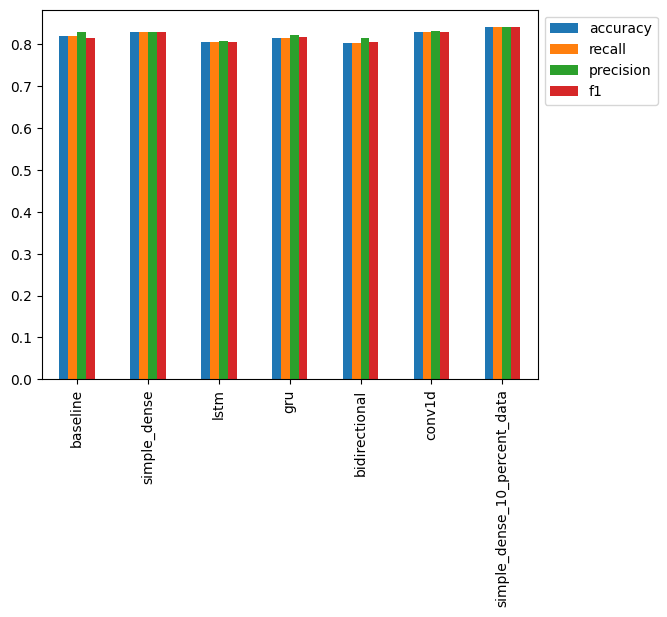

In [ ]:
all_model_results['accuracy'] = all_model_results['accuracy'] / 100
all_model_results.plot(kind = 'bar').legend(bbox_to_anchor = (1.0, 1.0));

<Axes: >

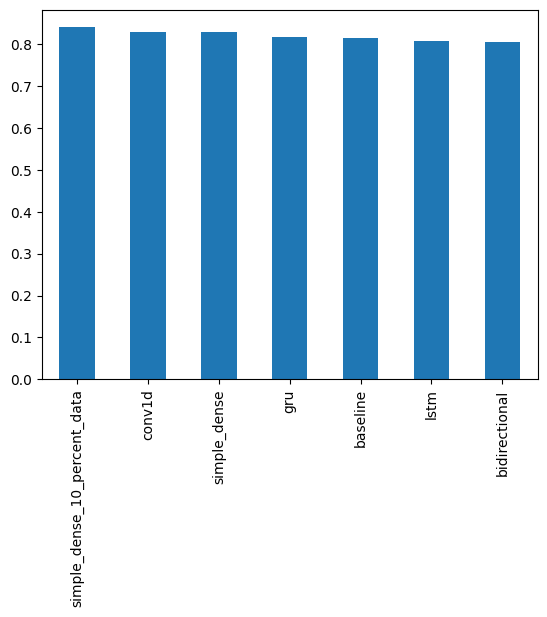

In [ ]:
all_model_results.sort_values('f1', ascending = False)['f1'].plot(kind = 'bar')

In [ ]:
val_df = pd.DataFrame({
    'text' : val_sentences,
    'target' : val_labels,
    'pred' : model_7_preds,
    'pred_prob' : tf.squeeze(model_7_pred_probs)
})

val_df.head(10)

,text,target,pred,pred_prob
0,isis recruiter excited to be talking to popula...,1,1.0,0.947544
1,jimmy fallon could barely keep it together dur...,0,0.0,0.091117
2,drunk ron weasley wishing harry potter 'happy ...,0,0.0,0.122681
3,hoosier hostility: not the american way,0,0.0,0.329957
4,turns out running doesn't wreck your knees aft...,0,0.0,0.406149
5,embarrassed library of congress can't believe ...,1,1.0,0.780755
6,biggest data leak in history reveals the globa...,0,0.0,0.009557
7,yeti releases abdominable crunch workout video,1,1.0,0.604801
8,tyson beckford recalls the craziness before sh...,0,0.0,0.038765
9,san francisco could become the first u.s. city...,0,0.0,0.055335


In [ ]:
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('pred_prob', ascending = False)
most_wrong[:10]

,text,target,pred,pred_prob
1182,that barefoot running shoe company lied to us all,0,1.0,0.988521
2272,scientists identify possible cause of huge ice...,0,1.0,0.988084
38,"ryan to unveil policy agenda, starting with an...",0,1.0,0.975137
1543,anderson cooper briefly speechless when gop st...,0,1.0,0.970447
476,"dutch heath authorities to kill 8,000 ducks to...",0,1.0,0.969646
768,breaking: israelites in sinai suddenly achieve...,0,1.0,0.967246
2090,palestinians starting to play on less uneven p...,0,1.0,0.966361
1262,supreme court to consider lifting class-action...,0,1.0,0.964802
713,missing puppy headed back to worried owners af...,0,1.0,0.964454
872,burglary suspect falls through restaurant ceil...,0,1.0,0.963753


In [ ]:
for row in most_wrong[:10].itertuples():
    _, text, target, pred, pred_prob = row
    print(f'Target : {target}, Pred : {pred}, Pred prob : {pred_prob}')
    print(f'Text : \n{text}\n')

Target : 0, Pred : 1.0, Pred prob : 0.9885213375091553
Text : 
that barefoot running shoe company lied to us all

Target : 0, Pred : 1.0, Pred prob : 0.9880836009979248
Text : 
scientists identify possible cause of huge ice shelf collapse

Target : 0, Pred : 1.0, Pred prob : 0.9751367568969727
Text : 
ryan to unveil policy agenda, starting with anti-poverty initiative

Target : 0, Pred : 1.0, Pred prob : 0.970446765422821
Text : 
anderson cooper briefly speechless when gop strategist swears he's never heard trump lie

Target : 0, Pred : 1.0, Pred prob : 0.9696457386016846
Text : 
dutch heath authorities to kill 8,000 ducks to prevent bird flu

Target : 0, Pred : 1.0, Pred prob : 0.9672456383705139
Text : 
breaking: israelites in sinai suddenly achieve freedom from pharaoh -- good times forecast

Target : 0, Pred : 1.0, Pred prob : 0.9663612842559814
Text : 
palestinians starting to play on less uneven playing field

Target : 0, Pred : 1.0, Pred prob : 0.9648016095161438
Text : 
supreme

In [ ]:
for row in most_wrong[-10:].itertuples():
    _, text, target, pred, pred_prob = row
    print(f'Target : {target}, Pred : {pred}, Pred prob : {pred_prob}')
    print(f'Text : \n{text}\n')

Target : 1, Pred : 0.0, Pred prob : 0.02559223212301731
Text : 
man who saw 'star wars: the force awakens' 6 times over holidays thought it was pretty good

Target : 1, Pred : 0.0, Pred prob : 0.02057667076587677
Text : 
magazine says you have sex and the city fever

Target : 1, Pred : 0.0, Pred prob : 0.017500009387731552
Text : 
'what were we talking about again?' says trump 15 seconds into phone call to family of fallen soldier

Target : 1, Pred : 0.0, Pred prob : 0.01530549954622984
Text : 
grandmother will live on in arguments over her wedding china

Target : 1, Pred : 0.0, Pred prob : 0.010620675049722195
Text : 
ivanka, donald jr., eric trump removed from white house after mother wins 25-year custody battle

Target : 1, Pred : 0.0, Pred prob : 0.010597576387226582
Text : 
guillermo del toro: 'in today's society, the true monsters are the horrifying, flesh-eating gargoyles'

Target : 1, Pred : 0.0, Pred prob : 0.008913499303162098
Text : 
june mademoiselle to feature ten ways to 

In [ ]:
# test_sentences = train_sentences_80_percent['headline'].tolist()
# test_sentences = train_sentences_80_percent.tolist()
test_samples = random.sample(sorted(train_sentences_80_percent), 10)
# random_index = random.randint(0, len(train_sentences_80_percent) - 5)
# test_samples = train_sentences_80_percent[random_index : random_index + 5]
for test_sample in test_samples:
    # pred_prob = tf.squeeze(model_7.predict([test_sample]))
    pred_prob = model_7.predict(np.array([test_sample], dtype = 'object'))
    pred = tf.round(pred_prob)
    print(f'Pred : {int(pred)}, prob : {pred_prob}')
    print(f'Text: \n{test_sample}\n')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Pred : 0, prob : [[0.00216284]]
Text: 
these christmas-inspired burgers are making the season bright

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Pred : 1, prob : [[0.55691856]]
Text: 
obama a little creeped out by how much everyone in kenya celebrating reelection victory

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Pred : 0, prob : [[0.00827756]]
Text: 
20 ways not to talk to your teenage daughter - then how to fix things

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Pred : 1, prob : [[0.7660088]]
Text: 
woman who started sentence with 'oh my god' really needs to stick landing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Pred : 1, prob : [[0.962505]]
Text: 
new gym member lingers by free weights for several seconds before returning to elliptical machine

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Pred : 0, prob : [[0.0210959]]
Text: 
mike pence won't explain donald trump's stance on deportations

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Pred : 0, prob : [[0.08651908]]
Text: 
cock

In [ ]:
sample_tweet = 'LAPD Arrests Everyone Who Lost Home In Fire'

In [ ]:
def predict_on_sentence(model, sentence):
    pred_prob = model.predict(np.array([sentence], dtype = 'object'))
    pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
    print(f'Pred : {pred_label}', '(sarcasm)' if pred_label > 0 else '(not sarcasm)', f'Pred Prob : {pred_prob[0][0]}')

In [ ]:
predict_on_sentence(model_7, sample_tweet)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Pred : 1.0 (sarcasm) Pred Prob : 0.5615028142929077


In [ ]:
sample_tweet_1 = 'Elderly Man Sets Sights On Big Chair'
sample_tweet_2 = 'Sun Unsure What It Has To Do To Get Humans To Worship It Again'

In [ ]:
predict_on_sentence(model_7, sample_tweet_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Pred : 1.0 (sarcasm) Pred Prob : 0.9751842617988586


In [ ]:
predict_on_sentence(model_7, sample_tweet_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Pred : 1.0 (sarcasm) Pred Prob : 0.9694427847862244
